# knock88

In [ ]:
from torch.nn import functional as F

class textCNN(nn.Module):
  def __init__(self, vocab_size, emb_size, padding_idx, output_size, out_channels, conv_params, drop_rate, emb_weights=None):
    super().__init__()
    if emb_weights != None:  # 指定があれば埋め込み層の重みをemb_weightsで初期化
      self.emb = nn.Embedding.from_pretrained(emb_weights, padding_idx=padding_idx)
    else:
      self.emb = nn.Embedding(vocab_size, emb_size, padding_idx=padding_idx)
    self.convs = nn.ModuleList([nn.Conv2d(1, out_channels, (kernel_height, emb_size), padding=(padding, 0)) for kernel_height, padding in conv_params])
    self.drop = nn.Dropout(drop_rate)
    self.fc = nn.Linear(len(conv_params) * out_channels, output_size)

  def forward(self, x):
    # x.size() = (batch_size, seq_len)
    emb = self.emb(x).unsqueeze(1)
    # emb.size() = (batch_size, 1, seq_len, emb_size)
    conv = [F.relu(conv(emb).squeeze(3)) for conv in (self.convs)]
    # conv[i].size() = (batch_size, out_channels, seq_len + padding * 2 - kernel_height + 1)
    max_pool = [F.max_pool1d(i, i.size(2)) for i in conv] #i.size()[2]
    # max_pool[i].size() = (batch_size, out_channels, 1) -> seq_len方向に最大値を取得
    max_pool_cat = torch.cat(max_pool, 1)
    # max_pool_cat.size() = (batch_size, len(conv_params) * out_channels, 1)  -> フィルター別の結果を結合
    out = self.fc(self.drop(max_pool_cat.squeeze(2)))
    # out.size() = (batch_size, output_size)
    return out


!pip install optuna


import optuna

def objective(trial):
  # チューニング対象パラメータのセット
  emb_size = int(trial.suggest_discrete_uniform('emb_size', 100, 400, 100))
  out_channels = int(trial.suggest_discrete_uniform('out_channels', 50, 200, 50))
  drop_rate = trial.suggest_discrete_uniform('drop_rate', 0.0, 0.5, 0.1)
  learning_rate = trial.suggest_loguniform('learning_rate', 5e-4, 5e-2)
  momentum = trial.suggest_discrete_uniform('momentum', 0.5, 0.9, 0.1)
  batch_size = int(trial.suggest_discrete_uniform('batch_size', 16, 128, 16))

  # 固定パラメータの設定
  VOCAB_SIZE = len(set(word2id.values())) + 1
  PADDING_IDX = len(set(word2id.values()))
  OUTPUT_SIZE = 4
  CONV_PARAMS = [[2, 0], [3, 1], [4, 2]]
  NUM_EPOCHS = 30

  # モデルの定義
  model = textCNN(VOCAB_SIZE, emb_size, PADDING_IDX, OUTPUT_SIZE, out_channels, CONV_PARAMS, drop_rate, emb_weights=weights)

  # 損失関数の定義
  criterion = nn.CrossEntropyLoss()

  # オプティマイザの定義
  optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)

  # デバイスの指定
  device = torch.cuda.set_device(0)

  # モデルの学習
  log = train_model(dataset_train, dataset_valid, batch_size, model, criterion, optimizer, NUM_EPOCHS, collate_fn=Padsequence(PADDING_IDX), device=device)

  # 損失の算出
  loss_valid, _ = calculate_loss_and_accuracy(model, dataset_valid, device, criterion=criterion)

  return loss_valid


# 最適化
study = optuna.create_study()
study.optimize(objective, timeout=7200)

[I 2024-07-22 07:00:01,676] A new study created in memory with name: no-name-019714d7-600e-4c0e-94d9-1f128bf7691c
<ipython-input-41-a46e81e9ba0a>:36: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., step=...) instead.
  emb_size = int(trial.suggest_discrete_uniform('emb_size', 100, 400, 100))
<ipython-input-41-a46e81e9ba0a>:37: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., step=...) instead.
  out_channels = int(trial.suggest_discrete_uniform('out_channels', 50, 200, 50))
<ipython-input-41-a46e81e9ba0a>:38: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., step=.

epoch: 1, loss_train: 0.9818, accuracy_train: 0.6446, loss_valid: 1.0126, accuracy_valid: 0.6154, 27.5901sec
epoch: 2, loss_train: 0.7944, accuracy_train: 0.7279, loss_valid: 0.8664, accuracy_valid: 0.6874, 27.3248sec
epoch: 3, loss_train: 0.6512, accuracy_train: 0.7679, loss_valid: 0.7772, accuracy_valid: 0.7181, 27.3658sec
epoch: 4, loss_train: 0.5393, accuracy_train: 0.7992, loss_valid: 0.7142, accuracy_valid: 0.7331, 26.8573sec
epoch: 5, loss_train: 0.4300, accuracy_train: 0.8613, loss_valid: 0.6663, accuracy_valid: 0.7549, 26.1914sec
epoch: 6, loss_train: 0.3483, accuracy_train: 0.8929, loss_valid: 0.6317, accuracy_valid: 0.7654, 27.1345sec
epoch: 7, loss_train: 0.2807, accuracy_train: 0.9286, loss_valid: 0.5969, accuracy_valid: 0.7879, 26.9332sec
epoch: 8, loss_train: 0.2275, accuracy_train: 0.9526, loss_valid: 0.5717, accuracy_valid: 0.7999, 27.1665sec
epoch: 9, loss_train: 0.1849, accuracy_train: 0.9701, loss_valid: 0.5642, accuracy_valid: 0.7999, 27.1332sec
epoch: 10, loss_tra

[I 2024-07-22 07:13:43,449] Trial 0 finished with value: 0.522794045325985 and parameters: {'emb_size': 300.0, 'out_channels': 100.0, 'drop_rate': 0.0, 'learning_rate': 0.027616552319303808, 'momentum': 0.8, 'batch_size': 80.0}. Best is trial 0 with value: 0.522794045325985.
[W 2024-07-22 07:13:45,733] Trial 1 failed with parameters: {'emb_size': 200.0, 'out_channels': 200.0, 'drop_rate': 0.1, 'learning_rate': 0.0020321689842630426, 'momentum': 0.9, 'batch_size': 80.0} because of the following error: RuntimeError('max_pool1d: Expected 2D or 3D (batch mode) tensor with optional 0 dim batch size for input, but got:[80, 200, 17, 101]').
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/optuna/study/_optimize.py", line 196, in _run_trial
    value_or_values = func(trial)
  File "<ipython-input-41-a46e81e9ba0a>", line 63, in objective
    log = train_model(dataset_train, dataset_valid, batch_size, model, criterion, optimizer, NUM_EPOCHS, collate_fn=Padsequen

RuntimeError: max_pool1d: Expected 2D or 3D (batch mode) tensor with optional 0 dim batch size for input, but got:[80, 200, 17, 101]

In [ ]:
# 結果の表示
print('Best trial:')
trial = study.best_trial
print('  Value: {:.3f}'.format(trial.value))
print('  Params: ')
for key, value in trial.params.items():
  print('    {}: {}'.format(key, value))

Best trial:
  Value: 0.523
  Params: 
    emb_size: 300.0
    out_channels: 100.0
    drop_rate: 0.0
    learning_rate: 0.027616552319303808
    momentum: 0.8
    batch_size: 80.0


In [ ]:
# パラメータの設定
VOCAB_SIZE = len(set(word2id.values())) + 1
#EMB_SIZE = int(trial.params['emb_size'])
EMB_SIZE = 300;
PADDING_IDX = len(set(word2id.values()))
OUTPUT_SIZE = 4
#OUT_CHANNELS = int(trial.params['out_channels'])
OUT_CHANNELS = 100
CONV_PARAMS = [[2, 0], [3, 1], [4, 2]]
#DROP_RATE = trial.params['drop_rate']
DROP_RATE = 0.4
#LEARNING_RATE = trial.params['learning_rate']
LEARNING_RATE = 0.013345934577557608
#BATCH_SIZE = int(trial.params['batch_size'])
BATCH_SIZE = 32
NUM_EPOCHS = 30

# モデルの定義
model = textCNN(VOCAB_SIZE, EMB_SIZE, PADDING_IDX, OUTPUT_SIZE, OUT_CHANNELS, CONV_PARAMS, DROP_RATE, emb_weights=weights)
print(model)

# 損失関数の定義
criterion = nn.CrossEntropyLoss()

# オプティマイザの定義
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=0.9)

# デバイスの指定
device = torch.cuda.set_device(0)

# モデルの学習
log = train_model(dataset_train, dataset_valid, BATCH_SIZE, model, criterion, optimizer, NUM_EPOCHS, collate_fn=Padsequence(PADDING_IDX), device=device)


textCNN(
  (emb): Embedding(9378, 300, padding_idx=9377)
  (convs): ModuleList(
    (0): Conv2d(1, 100, kernel_size=(2, 300), stride=(1, 1))
    (1): Conv2d(1, 100, kernel_size=(3, 300), stride=(1, 1), padding=(1, 0))
    (2): Conv2d(1, 100, kernel_size=(4, 300), stride=(1, 1), padding=(2, 0))
  )
  (drop): Dropout(p=0.4, inplace=False)
  (fc): Linear(in_features=300, out_features=4, bias=True)
)
epoch: 1, loss_train: 0.8064, accuracy_train: 0.7229, loss_valid: 0.8625, accuracy_valid: 0.6874, 27.7588sec
epoch: 2, loss_train: 0.5743, accuracy_train: 0.7990, loss_valid: 0.7301, accuracy_valid: 0.7331, 27.4831sec
epoch: 3, loss_train: 0.4003, accuracy_train: 0.8721, loss_valid: 0.6248, accuracy_valid: 0.7699, 28.1130sec
epoch: 4, loss_train: 0.2801, accuracy_train: 0.9250, loss_valid: 0.5660, accuracy_valid: 0.7946, 28.0507sec
epoch: 5, loss_train: 0.2001, accuracy_train: 0.9433, loss_valid: 0.5354, accuracy_valid: 0.8178, 28.1018sec
epoch: 6, loss_train: 0.1381, accuracy_train: 0.9721, l

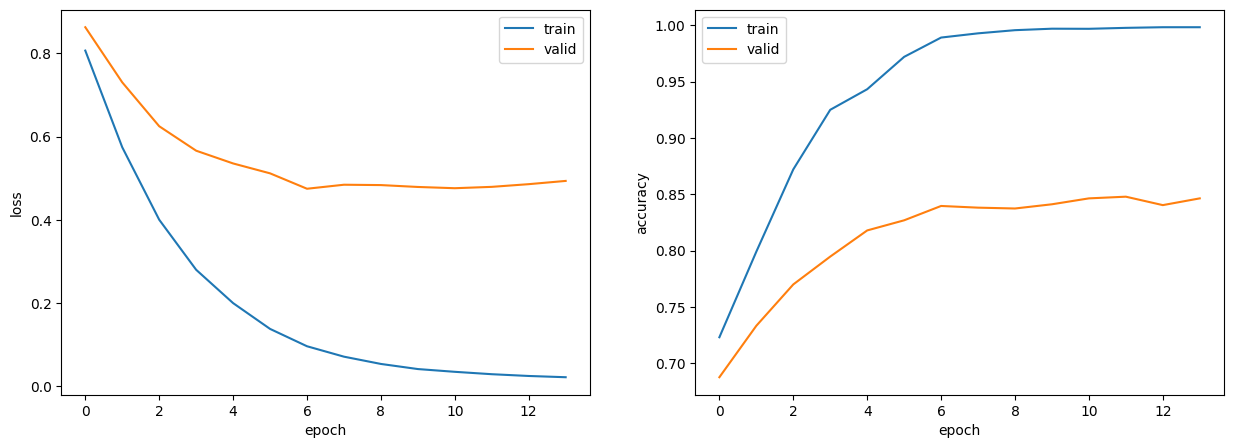

正解率（学習データ）：0.998
正解率（評価データ）：0.858


In [ ]:
# ログの可視化
visualize_logs(log)

# 正解率の算出
_, acc_train = calculate_loss_and_accuracy(model, dataset_train, device)
_, acc_test = calculate_loss_and_accuracy(model, dataset_test, device)
print(f'正解率（学習データ）：{acc_train:.3f}')
print(f'正解率（評価データ）：{acc_test:.3f}')